In [1]:
args = {}
args['model_path'] = './results/'
args['no_env'] = 1
args['no_motion_paths'] = 10000
args['total_input_size'] = 8
args['AE_input_size'] = 0
args['mlp_input_size'] = 8
args['output_size'] = 4
args['learning_rate'] = 0.01
args['device'] = 0
args['num_epochs'] = 5
args['batch_size'] = 100
args['data_path'] = './data/cartpole/'
args['data_file'] = 'train.pkl'
args['start_epoch'] = 0
args['env_type'] = 'cartpole'
args['world_size'] = [30., 40., 3.141592653589793, 2.]

In [2]:
"""
This implements the Kinodynamic Planning using MPNet, by using MPNet
to generate random samples, that will guide the SST algorithm.
"""
import torch
import model.AE.identity as cae_identity
from model.mlp import MLP
from model.mpnet import KMPNet
from tools import data_loader
from tools.utility import *
from plan_utility import cart_pole
import argparse
import numpy as np
import random
import os


if torch.cuda.is_available():
    torch.cuda.set_device(args['device'])
# environment setting
if args['env_type'] == 'cartpole':
    normalize = cart_pole.normalize
    unnormalize = cart_pole.unnormalize

cae = cae_identity
mlp = MLP
mpnet = KMPNet(args['total_input_size'], args['AE_input_size'], args['mlp_input_size'], args['output_size'],
               cae, mlp)
# load net
# load previously trained model if start epoch > 0
model_path='kmpnet_epoch_%d.pkl' %(args['start_epoch'])
torch_seed, np_seed, py_seed = 0, 0, 0
if args['start_epoch'] > 0:
    load_net_state(mpnet, os.path.join(args['model_path'], model_path))
    torch_seed, np_seed, py_seed = load_seed(os.path.join(args['model_path'], model_path))
    # set seed after loading
    torch.manual_seed(torch_seed)
    np.random.seed(np_seed)
    random.seed(py_seed)

if torch.cuda.is_available():
    mpnet.cuda()
    mpnet.mlp.cuda()
    mpnet.encoder.cuda()
    # here we use Adagrad because previous MPNet performs well under it
    mpnet.set_opt(torch.optim.Adagrad, lr=args['learning_rate'])
if args['start_epoch'] > 0:
    load_opt_state(mpnet, os.path.join(args['model_path'], model_path))

# load train and test data
print('loading...')
obs, dataset, targets, env_indices = data_loader.load_train_dataset(N=args['no_env'], \
                                            NP=args['no_motion_paths'], folder=args['data_path'], \
                                            fname=args['data_file'])
data=list(zip(dataset,targets,env_indices))
random.shuffle(data)
dataset,targets,env_indices=list(zip(*data))
dataset = list(dataset)
targets = list(targets)
env_indices = list(env_indices)
dataset = np.array(dataset)
targets = np.array(targets)
env_indices = np.array(env_indices)

# Train the Models
print('training...')
losses = []
for epoch in range(args['start_epoch']+1,args['num_epochs']+1):
    print('epoch' + str(epoch))
    for i in range(0,len(dataset),args['batch_size']):
        #print('epoch: %d, training... path: %d' % (epoch, i+1))
        dataset_i = dataset[i:i+args['batch_size']]
        targets_i = targets[i:i+args['batch_size']]
        env_indices_i = env_indices[i:i+args['batch_size']]
        # record
        bi = np.concatenate( (obs[env_indices_i, :args['AE_input_size']], dataset_i), axis=1).astype(np.float32)
        bt = targets_i
        bi = torch.FloatTensor(bi)
        bt = torch.FloatTensor(bt)
        bi, bt = normalize(bi, args['world_size']), normalize(bt, args['world_size'])
        mpnet.zero_grad()
        bi=to_var(bi)
        bt=to_var(bt)
        #print('before training losses:')
        #print(mpnet.loss(mpnet(bi), bt))
        losses.append(mpnet.loss(mpnet(bi), bt).cpu().data)
        mpnet.step(bi, bt)
        #print('after training losses:')
        #print(mpnet.loss(mpnet(bi), bt))
    # Save the models
    if epoch > 0:
        model_path='kmpnet_epoch_%d.pkl' %(epoch)
        save_state(mpnet, torch_seed, np_seed, py_seed, os.path.join(args['model_path'],model_path))
        # test



loading...
training...
epoch1
epoch2
epoch3
epoch4
epoch5


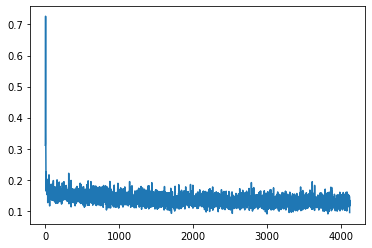

In [11]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(losses))), losses)
plt.show()

In [4]:
# load training paths
import pickle
from sparse_rrt import _sst_module
from sparse_rrt.systems import standard_cpp_systems
import time
def informed_sample(env, planner, start, goal):
    # repeat until finding a path
    max_iter = 500
    min_time_steps = 20
    max_time_steps = 200
    integration_step = 0.002
    x_new = np.array(start)
    sample_time = []
    plan_time_single = []
    for i in range(max_iter):
        # use MPNet to find the informed sample
        time1 = time.time()
        if i % 100 == 0:
            # use goal from time to time
            x_rand = goal
        else:
            x_in = np.concatenate([x_new, goal]).reshape(1, -1)
            x_in = torch.from_numpy(x_in).type(torch.FloatTensor)
            x_in = normalize(x_in, args['world_size']).cuda()
            x_rand = mpnet(x_in).cpu()[0]
            x_rand = unnormalize(x_rand, args['world_size'])
            x_rand = x_rand.cpu().data.numpy()
        sample_time.append(time.time() - time1)
        x_new = planner.step_with_sample(env, x_rand, min_time_steps, max_time_steps, integration_step)
        plan_time_single.append(time.time() - time1)
        # if x_new near goal it will terminate automatically
        #TODO: better iterative sampling method
        solution = planner.get_solution()
        if solution is not None:
            break
    solution = planner.get_solution()
    return solution, i, sample_time, plan_time_single

file = open('data/cartpole/train.pkl', 'rb')
paths = pickle.load(file)
#N = 100
max_iter = 500
# for each path, compare the number of samples needed for finding a "good" path
env = standard_cpp_systems.CartPole()
# for each BVP
min_time_steps = 20
max_time_steps = 200
integration_step = 0.002
low = []
high = []
state_bounds = env.get_state_bounds()
for i in range(len(state_bounds)):
    low.append(state_bounds[i][0])
    high.append(state_bounds[i][1])

    
uniform_suc = []
inform_suc = []
uniform_iter = []
inform_iter = []
uniform_cost = []
inform_cost = []
uniform_sample_time = []
uniform_plan_time_single = []
uniform_plan_time = []
inform_sample_time = []
inform_plan_time_single = []
inform_plan_time = []
num_paths = 1000
for i in range(num_paths):
    print("path %d" % (i))
    # randomly sample collision-free start and goal
    #print('random sampling trial:')
    start = np.random.uniform(low=low, high=high)
    end = np.random.uniform(low=low, high=high)
    planner = _sst_module.SSTWrapper(
        state_bounds=env.get_state_bounds(),
        control_bounds=env.get_control_bounds(),
        distance=env.distance_computer(),
        start_state=start,
        goal_state=end,
        goal_radius=0.5,
        random_seed=0,
        sst_delta_near=0.4,
        sst_delta_drain=0.2
    )
    # generate a path by using SST to plan for some maximal iterations
    time0 = time.time()
    for iter in range(max_iter):
        time1 = time.time()
        if iter % 100 == 0:
            # from time to time use the goal
            sample = end
        else:
            sample = np.random.uniform(low=low, high=high)
        uniform_sample_time.append(time.time() - time1)
        planner.step_with_sample(env, sample, min_time_steps, max_time_steps, integration_step)
        uniform_plan_time_single.append(time.time() - time1)
        # check if we find the solution, if so, stop planning
        solution = planner.get_solution()
        if solution is not None:
            break    
    solution = planner.get_solution()
    uniform_plan_time.append(time.time() - time0)

    if solution is None:
        #print('path %d: Uniform sampling failed.' % (i))
        uniform_suc.append(0)
        uniform_iter.append(np.inf)
        uniform_cost.append(np.inf)
        
    else:
        #print('path %d: Uniform succeeded with %d iterations.' % (i, iter))
        path, controls, costs = solution
        #print(path)
        #print('uniform sampling costs:')
        #print(np.sum(costs))
        uniform_suc.append(1)
        uniform_iter.append(iter)
        uniform_cost.append(np.sum(costs))

        
    # informed sampling
    # create a new planner
    planner = _sst_module.SSTWrapper(
        state_bounds=env.get_state_bounds(),
        control_bounds=env.get_control_bounds(),
        distance=env.distance_computer(),
        start_state=start,
        goal_state=end,
        goal_radius=0.5,
        random_seed=0,
        sst_delta_near=0.4,
        sst_delta_drain=0.2
    )    
    time0 = time.time()
    solution, iter, sample_time, plan_time_single = informed_sample(env, planner, start, end)
    inform_plan_time.append(time.time() - time0)
    inform_sample_time += sample_time
    inform_plan_time_single += plan_time_single
    
    if solution is not None:
        #print('path %d: Informed sampling succeeded with %d iterations.' % (i, iter))
        path, controls, costs = solution
        #print(path)
        #print('Informed sampling costs:')
        #print(np.sum(costs))      
        inform_suc.append(1)
        inform_iter.append(iter)
        inform_cost.append(np.sum(costs))
    else:
        #print('path %d: Informed sampling failed.' % (i))
        inform_suc.append(0)
        inform_iter.append(np.inf)
        inform_cost.append(np.inf)
        

path 0
path 1
path 2
path 3
path 4
path 5
path 6
path 7
path 8
path 9
path 10
path 11
path 12
path 13
path 14
path 15
path 16
path 17
path 18
path 19
path 20
path 21
path 22
path 23
path 24
path 25
path 26
path 27
path 28
path 29
path 30
path 31
path 32
path 33
path 34
path 35
path 36
path 37
path 38
path 39
path 40
path 41
path 42
path 43
path 44
path 45
path 46
path 47
path 48
path 49
path 50
path 51
path 52
path 53
path 54
path 55
path 56
path 57
path 58
path 59
path 60
path 61
path 62
path 63
path 64
path 65
path 66
path 67
path 68
path 69
path 70
path 71
path 72
path 73
path 74
path 75
path 76
path 77
path 78
path 79
path 80
path 81
path 82
path 83
path 84
path 85
path 86
path 87
path 88
path 89
path 90
path 91
path 92
path 93
path 94
path 95
path 96
path 97
path 98
path 99
path 100
path 101
path 102
path 103
path 104
path 105
path 106
path 107
path 108
path 109
path 110
path 111
path 112
path 113
path 114
path 115
path 116
path 117
path 118
path 119
path 120
path 121
path 122
pat

In [5]:
# printout success rate
print('uniform sampling success rate:')
print(np.sum(uniform_suc))
print('informed sampling success rate:')
print(np.sum(inform_suc))


uniform sampling success rate:
954
informed sampling success rate:
998


In [6]:
# plot iteration comparsion
iter_smaller = []
iter_larger = []
iter_equal = []
for i in range(len(inform_iter)):
    if inform_iter[i] < uniform_iter[i]:
        iter_smaller.append(1)
    elif inform_iter[i] == uniform_iter[i]:
        iter_equal.append(1)
    else:
        iter_larger.append(1)
print('smaller iterations:')
print(np.sum(iter_smaller))
print('equal iterations:')
print(np.sum(iter_equal))
print('larger iterations:')
print(np.sum(iter_larger))



smaller iterations:
382
equal iterations:
581
larger iterations:
37


In [10]:
# plot cost comparsion
cost_smaller = []
cost_equal = []
cost_larger = []
for i in range(len(inform_iter)):
    if inform_cost[i] < uniform_cost[i]:
        cost_smaller.append(1)
    elif inform_cost[i] == uniform_cost[i]:
        cost_equal.append(1)
    else:
        cost_larger.append(1)
print('smaller iterations:')
print(np.sum(cost_smaller))
print('equal iterations:')
print(np.sum(cost_equal))
print('larger iterations:')
print(np.sum(cost_larger))

print(np.mean(uniform_cost[uniform_cost!=np.inf]))
print(np.mean(inform_cost[uniform_cost!=np.inf]))

smaller iterations:
125
equal iterations:
193
larger iterations:
682
2.032
2.3480000000000003


In [8]:
# compare the time
print('uniform average time for sampling:')
print(np.mean(uniform_sample_time))
print('informed average time for sampling:')
print(np.mean(inform_sample_time))

print('uniform average time for planning one iteration:')
print(np.mean(uniform_plan_time_single))
print('informed average time for planning one iteration:')
print(np.mean(inform_plan_time_single))



uniform average time for sampling:
4.5457681831403256e-05
informed average time for sampling:
0.0011924057883996146
uniform average time for planning one iteration:
0.0007855385739078168
informed average time for planning one iteration:
0.0018842272827478371


In [9]:
# plot cost comparsion
time_smaller = []
time_equal = []
time_larger = []
for i in range(len(inform_iter)):
    if inform_plan_time[i] < uniform_plan_time[i]:
        time_smaller.append(1)
    elif inform_plan_time[i] == uniform_plan_time[i]:
        time_equal.append(1)
    else:
        time_larger.append(1)
print('smaller iterations:')
print(np.sum(time_smaller))
print('equal iterations:')
print(np.sum(time_equal))
print('larger iterations:')
print(np.sum(time_larger))

print(np.mean(uniform_plan_time))
print(np.mean(inform_plan_time))

smaller iterations:
208
equal iterations:
0.0
larger iterations:
792
0.1190761935710907
0.18591996693611146
